# **Loading the packages**

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import random

W&B:  0.12.21


In [18]:
wandb.init(project="Alzheimers2.0")

accuracy,▁▅▆▇▇██████████████████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▇▇▇▇▇▆▇█▇▇███▅██▇▇
val_loss,▇█▃▄▆▂▂▂▁▁▂▂▁▁▂▁▁▁▄▁▂▂▂
GFLOPS,0.16007
accuracy,0.99097
best_epoch,17
best_val_loss,0.21655
epoch,22
loss,0.02795


In [3]:
"""configs = dict(
    data_flag = 'alzheimers',
    image_width = 128,
    image_height = 128,
    batch_size = 32,
    model_name = 'MobileNet',
    pretrain_weights = 'imagenet',
    epochs = 30,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = 'sparse_categorical_crossentropy',
    metrics = ['acc'],
    earlystopping_patience = 5
)"""

"configs = dict(\n    data_flag = 'alzheimers',\n    image_width = 128,\n    image_height = 128,\n    batch_size = 32,\n    model_name = 'MobileNet',\n    pretrain_weights = 'imagenet',\n    epochs = 30,\n    init_learning_rate = 0.001,\n    lr_decay_rate = 0.1,\n    optimizer = 'adam',\n    loss_fn = 'sparse_categorical_crossentropy',\n    metrics = ['acc'],\n    earlystopping_patience = 5\n)"

In [19]:
labels =[]#image labels

for label in os.listdir("/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"):
    labels.append(label)

In [20]:
X_train = []#list for storing the image data
y_train = []#list for storing the labels of those respective image data
#image shape will be (224,224,3)
image_size = 128
for i in labels:
    folderpath = os.path.join("/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset",'train',i)
    for j in os.listdir(folderpath):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderpath = os.path.join('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset','test',i)
    for j in os.listdir(folderpath):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)/255.0
y_train = np.array(y_train)

Visualize the images

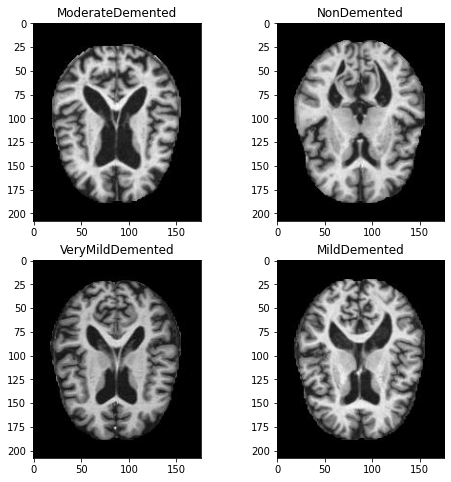

In [21]:
k=1
plt.figure(figsize=(8,8))
for i in labels:
    folderPath = os.path.join("/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset",'train',i)
    for j in os.listdir(folderPath):
        plt.subplot(2,2,k)
        img=cv2.imread(os.path.join(folderPath,j))
        plt.imshow(img)
        plt.title(i)
        k=k+1
        break
    

**Split the data**

In [22]:
#shuffle the data with the random seed 101
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [23]:
#split the datain 20% test and 80% train
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


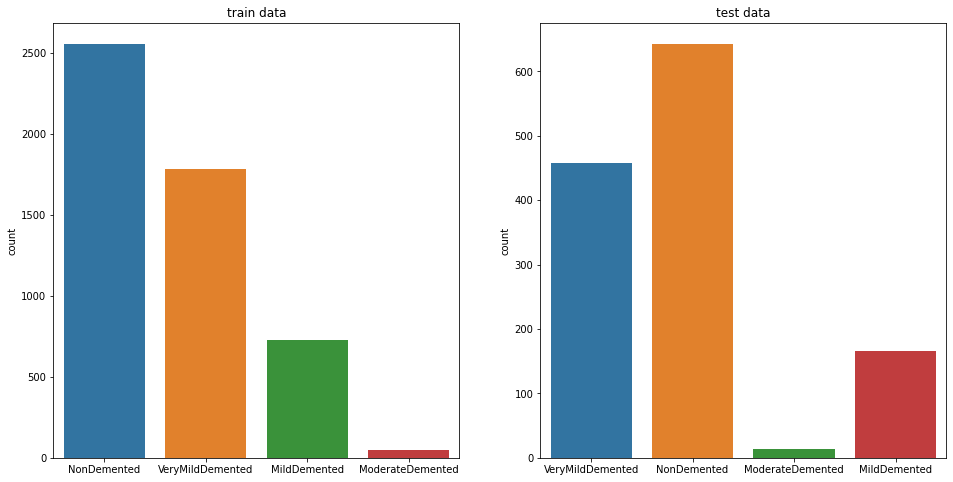

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.countplot(y_train)
plt.title("train data")
plt.subplot(1,2,2)
sns.countplot(y_test)
plt.title("test data")

plt.show()

ClASS IMBALACED

In [25]:
# since the labels that we have now are texts and we need to encode the in numerical format we can either use Label encoder or just encode according to index
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))

y_train = y_train_new


y_train = tf.keras.utils.to_categorical(y_train)  #transforming them to categorical format [0,1,0,0]

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

the model performnce and the data

In [26]:
input_shape=tf.keras.layers.Input(shape=(128,128,3))
mobile=tf.keras.applications.MobileNet(
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet",
    input_tensor=input_shape,
    pooling="avg",
    classifier_activation="softmax"
)
custom_layers=mobile.layers[-11].output
add_layer= tf.keras.layers.GlobalAveragePooling2D()(custom_layers)
add_layer = tf.keras.layers.Dropout(rate=0.5)(add_layer)

output_layer=Dense(len(labels),activation="softmax")(add_layer)
mobile_net_model=Model(inputs=input_shape,outputs=output_layer)

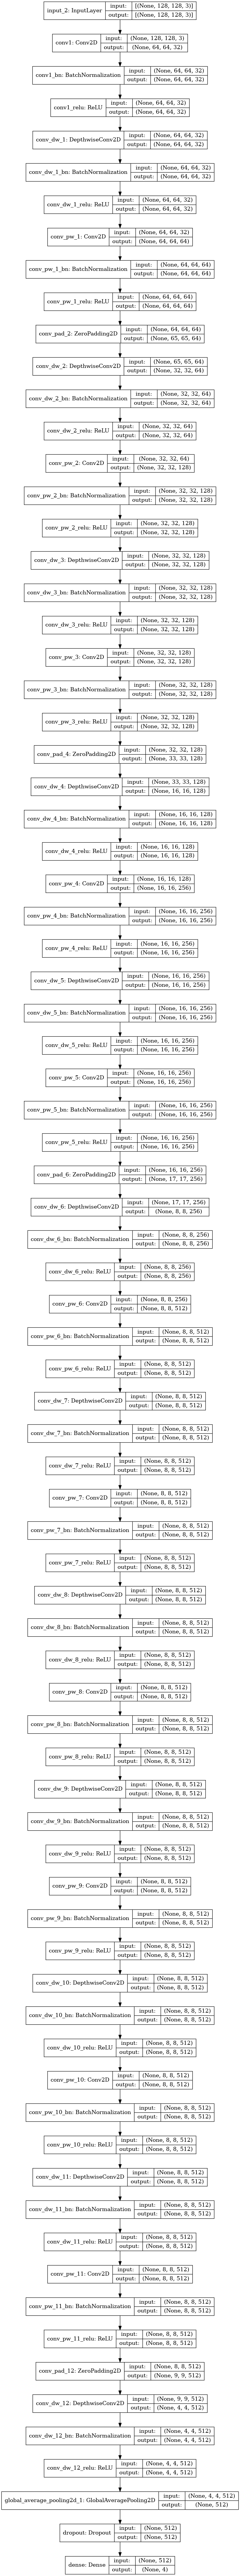

In [27]:
tf.keras.utils.plot_model(mobile_net_model,show_shapes=True)#shows the model architecture

In [28]:
#run = wandb.init(project='alzheimers', config=configs, job_type='train')
#config = wandb.config
earlystopper=tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

In [29]:
#for layer in mobile_net_model.layers[:-23]:
#    layer.trainable=False

checkpoint2 = ModelCheckpoint("/kaggle/working/mobinet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
callbacks = [earlystopper,checkpoint2,WandbCallback()]
mobile_net_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [30]:

with tf.device('/gpu:0'):
    hist=mobile_net_model.fit(X_train,y_train,epochs=30,validation_split=0.2,batch_size=32,verbose=1,callbacks=callbacks)
    
loss, acc = mobile_net_model.evaluate(X_test,y_test)


2022-11-27 09:36:14.420773: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 805306368 exceeds 10% of free system memory.
2022-11-27 09:36:15.353689: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 805306368 exceeds 10% of free system memory.
2022-11-27 09:36:16.243697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:36:16.244381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:36:16.245066: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2022-11-27 09:36:16.245321: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-11-27 09:36:16.245905: 

Epoch 1/30
128/128 [==============================] - 11s 67ms/step - loss: 1.5281 - accuracy: 0.5676 - val_loss: 0.6999 - val_accuracy: 0.7285

Epoch 00001: val_accuracy improved from -inf to 0.72852, saving model to /kaggle/working/mobinet.h5
Epoch 2/30
128/128 [==============================] - 8s 61ms/step - loss: 0.7241 - accuracy: 0.7673 - val_loss: 0.6694 - val_accuracy: 0.7734

Epoch 00002: val_accuracy improved from 0.72852 to 0.77344, saving model to /kaggle/working/mobinet.h5
Epoch 3/30
128/128 [==============================] - 8s 60ms/step - loss: 0.3375 - accuracy: 0.8833 - val_loss: 1.9426 - val_accuracy: 0.6406

Epoch 00003: val_accuracy did not improve from 0.77344
Epoch 4/30
128/128 [==============================] - 8s 61ms/step - loss: 0.1844 - accuracy: 0.9316 - val_loss: 1.3653 - val_accuracy: 0.6611

Epoch 00004: val_accuracy did not improve from 0.77344
Epoch 5/30
128/128 [==============================] - 8s 60ms/step - loss: 0.1283 - accuracy: 0.9534 - val_los

In [31]:
#model performance on test data
mobile_net_model.evaluate(X_test,y_test)

40/40 [==============================] - 1s 14ms/step - loss: 0.1502 - accuracy: 0.9602


[0.15020227432250977, 0.960156261920929]

SAVE MODEL

In [32]:
mobile_net_model.save("/kaggle/working/saved_mobile_net_model.h5")#saving the mobilenet model

In [33]:
#load saved model
mobi_net=tf.keras.models.load_model("/kaggle/working/mobinet.h5")
mobi_net.evaluate(X_train,y_train)

2022-11-27 09:42:16.966119: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1006632960 exceeds 10% of free system memory.


160/160 [==============================] - 3s 14ms/step - loss: 0.0457 - accuracy: 0.9875


[0.04571797698736191, 0.987500011920929]

In [34]:
mobi_net.evaluate(X_test,y_test)

40/40 [==============================] - 1s 20ms/step - loss: 0.1502 - accuracy: 0.9602


[0.15020227432250977, 0.960156261920929]

In [35]:
wandb.finish

<function wandb.sdk.wandb_run.finish(exit_code: int = None, quiet: bool = None) -> None>

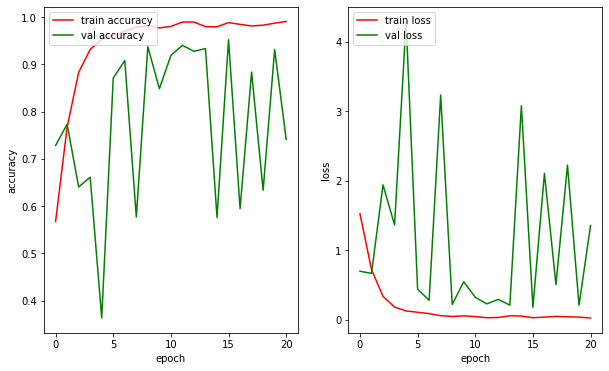

In [36]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(hist.history["accuracy"],color="red")
plt.plot(hist.history["val_accuracy"],color="green")
#plt.plot(hist.history["loss"],color="yellow")
#plt.plot(hist.history["val_loss"],color="orange")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history["loss"],color="red")
plt.plot(hist.history["val_loss"],color="green")
#plt.plot(hist.history["loss"],color="yellow")
#plt.plot(hist.history["val_loss"],color="orange")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

Some predictions

In [37]:
i
#predict labels
def predict_out(image,algo):
    out=np.argmax(algo.predict(image),axis=1)
    if out==0:
        return "predicted ModerateDemented"
    if out==1:
        return "predicted NonDemented"
    if out==2:
        return "VeryMildDemented"
    if out==3:
        return "predicted MildDemented"

def true_labels(data,labels):#fetch true labels 
    return labels[data]

def label_encoded_predict(data): #from onehotencoded to labelencoded
    data=np.argmax(data,axis=1)
    return data


VeryMildDemented
VeryMildDemented


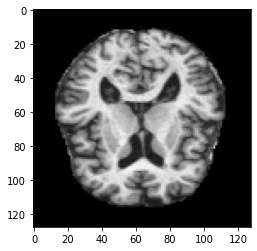

In [40]:
n=random.randint(1,100)
check_data=np.expand_dims(X_test[n],axis=0)
print(predict_out(check_data,mobi_net))
print(true_labels(y_test_new[n],labels))
plt.imshow(check_data[0])

In [41]:
#classification report 
pred=mobi_net.predict(X_test)
pred=label_encoded_predict(pred)
print(classification_report(y_test_new,pred, target_names=labels))

                  precision    recall  f1-score   support

ModerateDemented       1.00      1.00      1.00        14
     NonDemented       0.99      0.96      0.98       643
VeryMildDemented       0.91      0.99      0.95       457
    MildDemented       0.99      0.87      0.93       166

        accuracy                           0.96      1280
       macro avg       0.97      0.96      0.96      1280
    weighted avg       0.96      0.96      0.96      1280

